# Libraries Required

In [38]:
# Load necessary libraries 
library(readr)       # For reading CSV files
library(tidyverse)   # Includes ggplot2, dplyr, tibble, etc.
library(caret)       # For confusion matrix, accuracy, and evaluation metrics
library(class)       # For k-NN
library(e1071)       # For SVM and Naive Bayes
library(ggfortify)   # For PCA visualization
library(pROC)        # For ROC curves and AUC


#  Load and Prepare the Dataset [ine dataset]

In [37]:
# Read dataset
wine <- read_csv("/Users/zabir/Downloads/Spring-25/Data Analytics/R Lab/Lab 4/wine/wine.csv")
colnames(wine) <- c("class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", 
                    "Total phenols", "Flavanoids", "Nonflavanoid phenols", "Proanthocyanins", 
                    "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline")

wine$class <- as.factor(wine$class)

# Standardize features (excluding class)
wine_scaled <- wine
wine_scaled[,-1] <- scale(wine[,-1])

# Split into training and testing sets (80/20)
set.seed(123)
train_index <- createDataPartition(wine_scaled$class, p = 0.8, list = FALSE)
train_data <- wine_scaled[train_index, ]
test_data <- wine_scaled[-train_index, ]

# Subset of variables to use (based on importance or EDA)
selected_features <- c("Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", 
                    "Total phenols", "Flavanoids", "Nonflavanoid phenols", "Proanthocyanins", 
                    "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline")

# Prepare training and test sets
train_x <- train_data[, selected_features]
train_y <- train_data$class
test_x <- test_data[, selected_features]
test_y <- test_data$class
head(train_x)

Rows: 177 Columns: 14
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): 1, 14.23, 1.71, 2.43, 15.6, 127, 2.8, 3.06, .28, 2.29, 5.64, 1.04,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.2551008,-0.50020530,-0.8221529,-2.4930372,0.02909756,0.5710456,0.7375437,-0.8208101,-0.5370519,-0.290306650,0.4059482,1.1284966,0.9683055
0.2056453,0.01796903,1.1045562,-0.2748590,0.09964918,0.8104843,1.2181890,-0.4999191,2.1399040,0.268966296,0.3186634,0.8023031,1.3970348
1.7016732,-0.34832662,0.4865552,-0.8144158,0.94626865,2.4865554,1.4685250,-0.9812556,1.0376281,1.181011408,-0.4232572,1.1994082,2.3338876
1.4914875,-0.51807338,0.3047901,-1.2940219,0.87571703,1.5607256,1.3683906,-0.1790282,0.6702028,0.729290952,0.4059482,0.3484686,2.2386144
1.7264010,-0.41979894,0.3047901,-1.4738742,-0.25310893,0.3316069,0.4972211,-0.4999191,0.6876992,0.083976014,0.2750210,1.3837785,1.7304908
1.3183934,-0.16964581,0.8864382,-0.5746128,1.51068164,0.4912327,0.4872077,-0.4196964,-0.5895412,-0.002065978,0.4495905,1.3837785,1.7463697


# SVM with Linear Kernel + Hyperparameter Tuning

In [25]:
# Step 1: Standardize column names to be syntactically valid
colnames(train_x) <- make.names(colnames(train_x))
colnames(test_x) <- make.names(colnames(test_x))

# Step 2: Rebuild training data for SVM model
train_df_linear <- data.frame(class = train_y, train_x)

# Step 3: Tune and train the SVM with linear kernel
set.seed(123)
tuned_svm_linear <- tune.svm(class ~ ., data = train_df_linear,
                             kernel = "linear",
                             cost = 2^(-1:4))
best_svm_linear <- tuned_svm_linear$best.model

# Step 4: Predict using test data (column names now match)
pred_linear <- predict(best_svm_linear, newdata = test_x)
pred_linear

1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
 1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  1  2  2  2  2  2  2 
27 28 29 30 31 32 33 34 
 3  3  3  3  3  3  3  3 
Levels: 1 2 3

# SVM with Radial Kernel

In [26]:
# Ensure column names are consistent
colnames(train_x) <- make.names(colnames(train_x))
colnames(test_x) <- make.names(colnames(test_x))

# Combine into training data frame with proper column names
train_df_radial <- data.frame(class = train_y, train_x)

# Tune radial SVM
set.seed(123)
tuned_svm_radial <- tune.svm(class ~ ., data = train_df_radial,
                             kernel = "radial",
                             gamma = 2^(-5:2), cost = 2^(-1:4))

# Best model and predictions
best_svm_radial <- tuned_svm_radial$best.model
pred_radial <- predict(best_svm_radial, newdata = test_x)


# k-NN Classification

In [27]:
# Convert to matrices for knn()
train_x_knn <- as.matrix(train_x)
test_x_knn <- as.matrix(test_x)

# Labels as factors
train_y_knn <- as.factor(train_y)
test_y_knn <- as.factor(test_y)

# k-NN prediction
set.seed(123)
knn_pred <- knn(train = train_x_knn, test = test_x_knn, cl = train_y_knn, k = 5)


# Evaluation Metrics

In [28]:
library(caret)

evaluate_model <- function(true, pred, model_name) {
  cm <- confusionMatrix(pred, true)
  precision <- cm$byClass[, "Precision"]
  recall <- cm$byClass[, "Recall"]
  f1 <- 2 * (precision * recall) / (precision + recall)
  result <- data.frame(Model = model_name,
                       Precision = round(mean(precision, na.rm = TRUE), 3),
                       Recall = round(mean(recall, na.rm = TRUE), 3),
                       F1 = round(mean(f1, na.rm = TRUE), 3))
  return(result)
}

# Combine all model evaluation results
results <- bind_rows(
  evaluate_model(test_y, pred_linear, "SVM (Linear)"),
  evaluate_model(test_y, pred_radial, "SVM (Radial)"),
  evaluate_model(test_y, knn_pred, "k-NN (k=5)")
)

print(results)


         Model Precision Recall    F1
1 SVM (Linear)     0.948  0.939 0.942
2 SVM (Radial)     0.978  0.963 0.969
3   k-NN (k=5)     0.939  0.952 0.942


#  Load and Prepare the Dataset

In [32]:


# Load dataset
dataset <- read_csv("NY-House-Dataset.csv")

# Remove extreme outliers (top 1% in price)
dataset <- dataset %>% 
  filter(PRICE < quantile(PRICE, 0.99, na.rm = TRUE))

# Remove any unusual square footage entry
dataset <- dataset %>% filter(PROPERTYSQFT != 2184.207862)

# Remove missing values
dataset <- na.omit(dataset)

# Transform variables
dataset$logPRICE <- log(dataset$PRICE)
dataset$logPROPERTYSQFT <- log(dataset$PROPERTYSQFT)


Rows: 4801 Columns: 17
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (11): BROKERTITLE, TYPE, ADDRESS, STATE, MAIN_ADDRESS, ADMINISTRATIVE_AR...
dbl  (6): PRICE, BEDS, BATH, PROPERTYSQFT, LATITUDE, LONGITUDE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


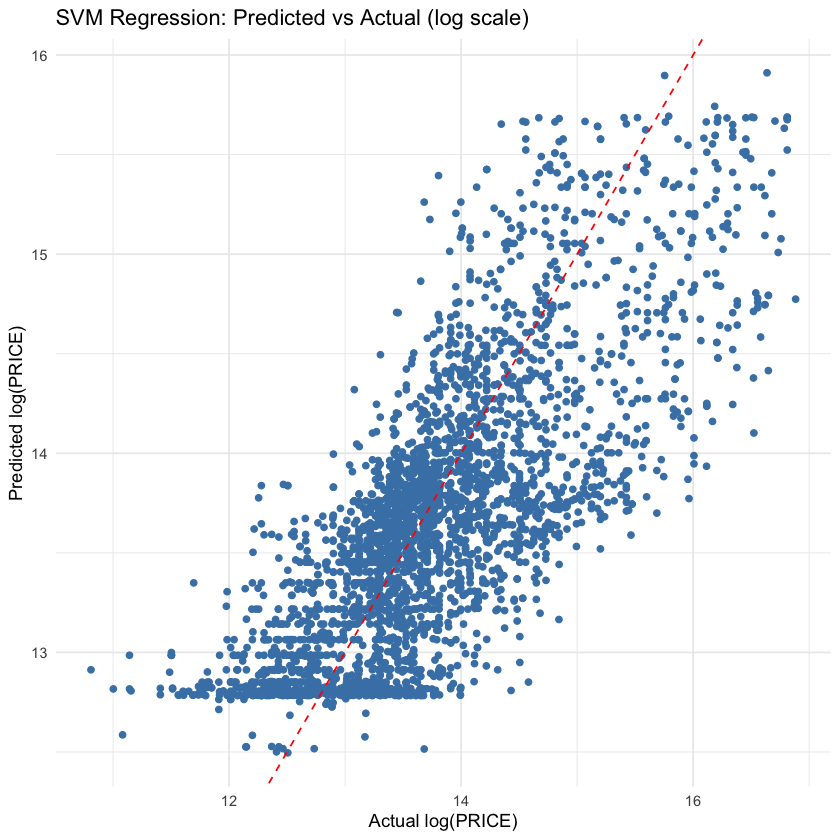

In [34]:
# Train SVM regression model
set.seed(123)
svm_model <- svm(logPRICE ~ logPROPERTYSQFT, data = dataset)

# Predict
svm_pred <- predict(svm_model, newdata = dataset)

# Plot: Predicted vs Real Price (SVM)
ggplot(dataset, aes(x = logPRICE, y = svm_pred)) +
  geom_point(color = "steelblue") +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
  labs(title = "SVM Regression: Predicted vs Actual (log scale)",
       x = "Actual log(PRICE)", y = "Predicted log(PRICE)") +
  theme_minimal()


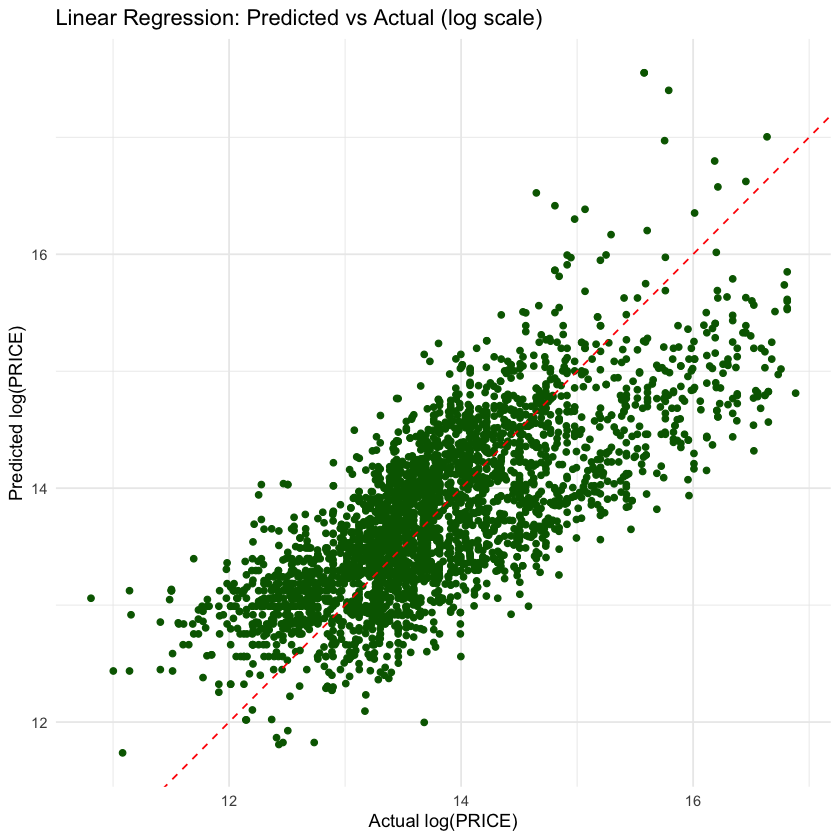

In [35]:
# Train linear regression model
lm_model <- lm(logPRICE ~ logPROPERTYSQFT, data = dataset)

# Predict
lm_pred <- predict(lm_model, newdata = dataset)

# Plot: Predicted vs Real Price (Linear)
ggplot(dataset, aes(x = logPRICE, y = lm_pred)) +
  geom_point(color = "darkgreen") +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
  labs(title = "Linear Regression: Predicted vs Actual (log scale)",
       x = "Actual log(PRICE)", y = "Predicted log(PRICE)") +
  theme_minimal()


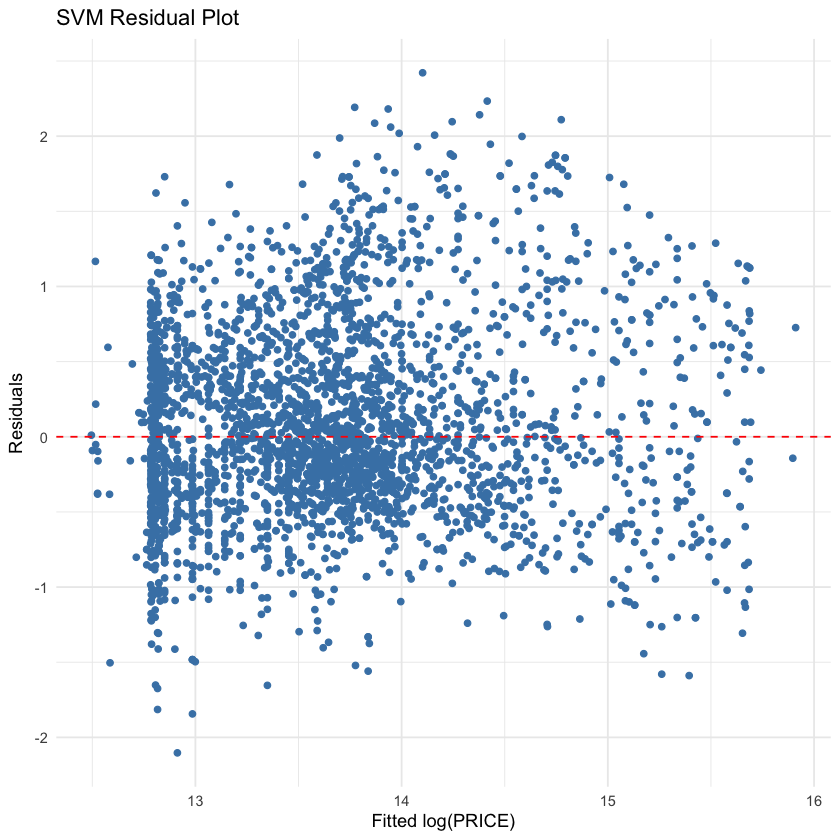

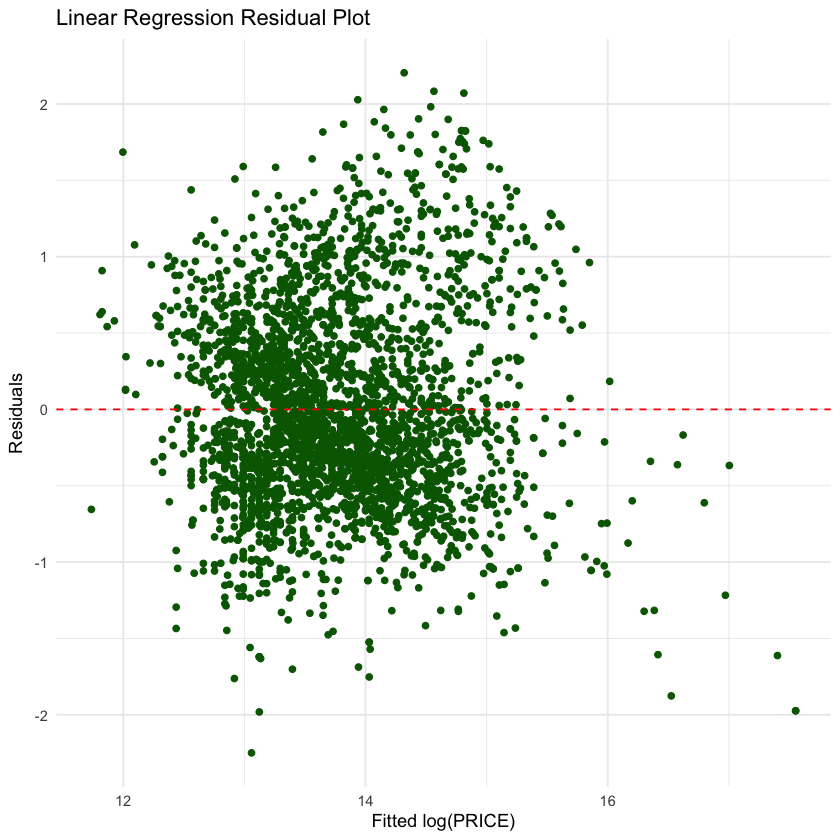

In [36]:
# Residuals
svm_residuals <- dataset$logPRICE - svm_pred
lm_residuals <- dataset$logPRICE - lm_pred

# Residual Plot: SVM
ggplot(data.frame(Fitted = svm_pred, Residuals = svm_residuals),
       aes(x = Fitted, y = Residuals)) +
  geom_point(color = "steelblue") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "SVM Residual Plot", x = "Fitted log(PRICE)", y = "Residuals") +
  theme_minimal()

# Residual Plot: Linear Regression
ggplot(data.frame(Fitted = lm_pred, Residuals = lm_residuals),
       aes(x = Fitted, y = Residuals)) +
  geom_point(color = "darkgreen") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Linear Regression Residual Plot", x = "Fitted log(PRICE)", y = "Residuals") +
  theme_minimal()
